# Population stratification illustration using slicing of remote VCF with Bioconductor

We will acquire a modest collection of SNP calls from chr17, and project the genotype configurations via principal components to expose population substructure.

## Create references to the EBI VCF repository

Bioconductor’s ldblock package includes utilities for working with collections of VCF, typically decomposed by chromosome.

In [21]:
library(BiocManager)
inplist = rownames(installed.packages())
if (!("snpStats" %in% inplist)) install("snpStats")
if (!("ldblock" %in% inplist)) install("vjcitn/ldblock")
if (!("terravar" %in% inplist)) install("vjcitn/terravar")


In [22]:
library(ldblock)
library(GenomicFiles)
library(VariantAnnotation)

## Read a slice of VCF corresponding to a region of chr17

EBI has updated 1000 genomes calls. We will interrogate a tabix-indexed VCF for chr17 via HTTP. An object that organizes multiple chromosomes is created using stack1kg from the ldblock package.

In [23]:
st = stack1kg("17")

We use a ScanVcfParam to define a slice of genome.

In [24]:
sp = ScanVcfParam(geno="GT", 
    which=GRanges("17", IRanges(32e6,33.75e6)))
myread = readVcfStack(st, param=sp) 

`readVcfStack` produces a CollapsedVCF instance in memory.  See the documentation for the VariantAnnotation package for details on this data structure.

In [25]:
myread

class: CollapsedVCF 
dim: 49194 2548 
rowRanges(vcf):
  GRanges with 5 metadata columns: paramRangeID, REF, ALT, QUAL, FILTER
info(vcf):
  DataFrame with 12 columns: AF, AC, NS, AN, EAS_AF, EUR_AF, AFR_AF, AMR_AF,...
info(header(vcf)):
             Number Type    Description                                        
   AF        A      Float   Estimated allele frequency in the range (0,1)      
   AC        A      Integer Total number of alternate alleles in called geno...
   NS        1      Integer Number of samples with data                        
   AN        1      Integer Total number of alleles in called genotypes        
   EAS_AF    A      Float   Allele frequency in the EAS populations calculat...
   EUR_AF    A      Float   Allele frequency in the EUR populations calculat...
   AFR_AF    A      Float   Allele frequency in the AFR populations calculat...
   AMR_AF    A      Float   Allele frequency in the AMR populations calculat...
   SAS_AF    A      Float   Allele frequency

## Transform the VCF content to rare allele counts

We use tools in David Clayton’s snpStats package to achieve a compact representation of (possibly uncertain) genotype calls. This enables us to filter to SNP with MAF exceeding a given threshold, and, later, to compute a PCA.

In [26]:
library(snpStats)
mymat = genotypeToSnpMatrix(myread)
## non-single nucleotide variations are set to NA
cs = col.summary(mymat[[1]])
sum(cs[,"MAF"]>.1, na.rm=TRUE)

non-single nucleotide variations are set to NA


[1] 2909

## Build a matrix of B-allele counts

We'll use SNP with MAF exceeding 10%, and build the sample x SNP matrix.

In [27]:
kpsnp = which(cs[,"MAF"]>.1)
cmat = matrix(0, nr=nrow(mymat[[1]]), nc=length(kpsnp))
for (i in seq_len(length(kpsnp))) {
  cmat[,i] = as(mymat[[1]][,kpsnp[i]], "numeric")
  }
rownames(cmat) = rownames(mymat[[1]])

## Compute principal components and plot

In [28]:
pp = prcomp(cmat)

In [29]:
dim(pp$x)

[1] 2548 2548

In [30]:
library(ggplot2)

library(terravar)
data("geog_1kg")
rownames(geog_1kg) = geog_1kg[,1]
newdf = data.frame(pp$x[,1:4], pop=geog_1kg[rownames(pp$x), "Population"],
    superpop = geog_1kg[rownames(pp$x), "superpop"])

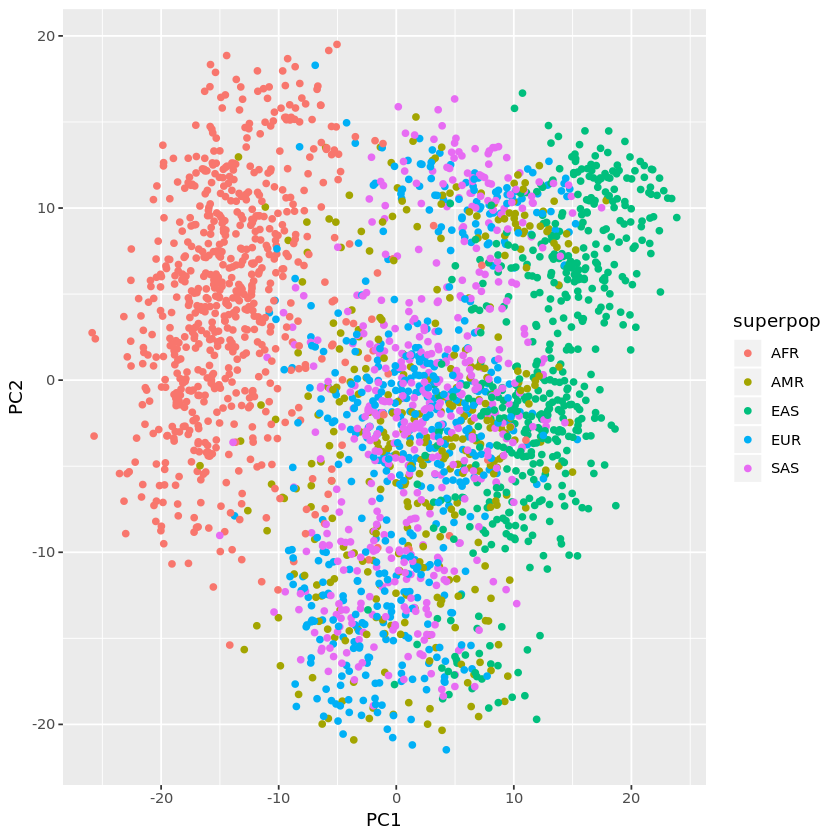

In [31]:
ggplot(newdf, aes(x=PC1, y=PC2, colour=superpop)) + geom_point()